In [299]:
import tushare as ts
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime
import requests
from bs4 import BeautifulSoup
%matplotlib inline
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

# Here we're implementing strategy 2

Similar to before, we still use the position for each fund published every season, then we uses the rank for each week. Here we start from 2020/04/11 until now <br>
Notice here that we rank the funds every week (5 trading days), like: <br>
2020/04/11 - 2020/04/15 <br>
However, we trade all the stocks every Monday since we need the entire weekend to do the analysis <br>

In [410]:
# First we need to scripe from 天天基金网
# We starting from datetime now
day = 7
start = datetime.date(2021, 3 , 15)
end = datetime.date(2021, 4 , 9)
datetime.timedelta(days = day)
# we create a datetime array for starting and ending date
startList = np.array([str(start + datetime.timedelta(days = 14*x)).replace('-','') for x in range(5)]) # so far, we have 9 weeks
endList = np.array([str(end + datetime.timedelta(days = 14*x)).replace('-','') for x in range(5)])

start = datetime.date(2021, 4 , 12)
end = datetime.date(2021, 4 , 23)
start_List = np.array([str(start + datetime.timedelta(days = 14*x)).replace('-','') for x in range(5)]) # so far, we have 9 weeks
end_List = np.array([str(end + datetime.timedelta(days = 14*x)).replace('-','') for x in range(5)])

# 'ddesc' for descending; 'dasc' for ascending
url = 'http://fund.eastmoney.com/data/fundranking.html#tall;c0;r;sqjzf;pn50;ddesc;qsd'+\
      '20210412'+\
      ';qed'+\
      '20210416'+\
      ';qdii;zq;gg;gzbd;gzfs;bbzt;sfbb'

page = requests.get(url)
soup1 = BeautifulSoup(page.content, 'html.parser')  

ts.set_token('bb041845ae29bf5ae6414c14685c2da18f03f955c1d39d9f4ab6b947')
pro = ts.pro_api()

In [411]:
print(startList, endList)
print(start_List, end_List)

['20210315' '20210329' '20210412' '20210426' '20210510'] ['20210409' '20210423' '20210507' '20210521' '20210604']
['20210412' '20210426' '20210510' '20210524' '20210607'] ['20210423' '20210507' '20210521' '20210604' '20210618']


In [412]:
def get_funds_ranking(start_time, end_time):
    
    # 'ddesc' for descending; 'dasc' for ascending
    url = 'http://fund.eastmoney.com/data/fundranking.html#thh;c0;r;sqjzf;pn50;ddesc;qsd'+\
          start_time+\
          ';qed'+\
          end_time+\
          ';qdii;zq;gg;gzbd;gzfs;bbzt;sfbb'

    driver = webdriver.Chrome(executable_path="/Users/zhangluyang/Desktop/QuantProject/chromedriver")
    driver.maximize_window()
    wait = WebDriverWait(driver, 10)
    driver.get(url)

    # wait for the complete page load
    wait.until(EC.invisibility_of_element_located((By.ID, "preload")))
    # parse the HTML
    soup = BeautifulSoup(driver.page_source, "html.parser")
    driver.close()

    # set the index to be 4
    table = soup.find_all('table')[4]
    rows = table.find_all(lambda tag: tag.name=='tr')
    
    
    # getting the dataframe
    title = rows[0].findAll(text=True)
    title = list(filter(('\n').__ne__, title))

    # we need to remove 1st, 3rd, -2, -1 position
    # also, we need to get the url
    title = [title[1]] + title[3:-2]
    title = title + ['URL_General', 'URL_Holdings']
    array = np.array([title])

    for i in range(1,len(rows)):
        # append the funds' url
        info = np.array(rows[i].findAll(text=True))
        #.append(rows[i].find_all('a', href=True)[0]['href'])
        general_url = str(rows[i].find_all('a', href=True)[0]['href'])
        info = np.append(info, general_url)
        # append the funds' holdings' url
        info = np.append(info,'http://fundf10.eastmoney.com/ccmx_'+info[1]+'.html')
        array = np.concatenate((array, [info]))

    ranking_funds = pd.DataFrame(data=array[1:,1:],    
                           index=array[1:,0],    
                           columns=array[0,1:]) 
    
    return ranking_funds



def get_holdings(url):
    
    driver = webdriver.Chrome(executable_path="/Users/zhangluyang/Desktop/QuantProject/chromedriver")
    driver.maximize_window()
    wait = WebDriverWait(driver, 10)
    driver.get(url)

    # wait for the complete page load
    wait.until(EC.invisibility_of_element_located((By.ID, "preload")))

    # parse the HTML
    soup = BeautifulSoup(driver.page_source, "html.parser")
    driver.close()

    table = soup.find_all("div", {"class": "boxitem w790"})
    rows = table[0].find_all(lambda tag: tag.name=='tr')
    
    if rows == []:
        return pd.DataFrame()
    
    #title = rows[0].findAll(text=True)
    title = ['股票代码', '股票名称']
    array = np.array([title])

    for i in range(1,len(rows)):
        # here the string lenght should be bigger than default 8
        info = np.array(rows[i].findAll(text=True), dtype=np.dtype('U100'))
        if info[1][0] == '0' or info[1][0] == '3':
            info[1] = str(info[1]) + ".SZ"
        else:
            info[1] = str(info[1]) + ".SH"
        info_new = [info[1]] + [info[2]]
        array = np.concatenate((array, [info_new]))

    ranking_holdings = pd.DataFrame(data=array[1:,1:],    
                               index=array[1:,0],    
                               columns=array[0,1:])
    
    return ranking_holdings

# The best performing strategy: 4 weeks predicts 2 weeks

[1.         1.00903026 1.01257331 1.01204536 0.99824578 1.0308742
 1.05303547 1.06769316 1.05831904 1.10439526]
[1.10439526 1.14378543 1.17287354 1.17906429 1.18194064 1.14850744
 1.10559448]
[1.10559448 1.07723302 1.0753222  1.04922609 1.08151086 1.14327128
 1.14159073 1.17542541 1.16956016 1.17566265]
[1.17566265 1.21581419 1.1954693  1.20566948 1.2241965  1.2605009
 1.26307092 1.25710491 1.25480049 1.28335961]


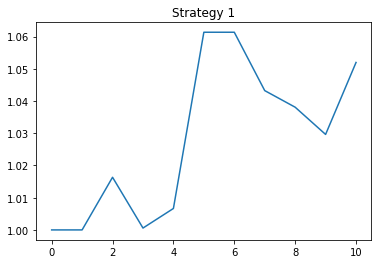

In [415]:
portfolio = [1]
for i in range(len(endList)-1):
    starting_date1 = startList[i]
    ending_date1 = endList[i]
    
    df_total = pd.DataFrame()
    # containing the best formoing 50 funds
    dfFunds = get_funds_ranking(starting_date1, ending_date1)
    num_funds = 35
    
    # we can set the select how many funds here
    for index, row in dfFunds.iterrows():
        if int(index) < num_funds:
            url = row[-1]
            tempHoldings = get_holdings(url)
            time.sleep(1)
            df_total = pd.concat([df_total, tempHoldings], axis=0)

    df_total.reset_index(inplace=True)
    df_total.columns = ['股票代码', '股票名称']
    stock_list = df_total['股票代码'].value_counts().to_frame()
    # take the top 10 stocks
    stock_list = stock_list.head(10)
    stock_list['weight'] = stock_list['股票代码']/sum(stock_list['股票代码'])
    stock_list.reset_index(inplace=True)
    stock_list.columns = ['Tick', 'Number', 'Weight']

    
    starting_date2 = start_List[i]
    ending_date2 = end_List[i]
    tickStart = stock_list['Tick']
    tick = tickStart[0]
    num = len(ts.pro_bar(ts_code=tick, adj='qfq', start_date=starting_date2, end_date=ending_date2))
    temp = np.array([0 for x in range(num)])
    endingP = portfolio[-1]
    for i in range(len(stock_list)):
        tick = tickStart[i]
        df_info = ts.pro_bar(ts_code=tick, adj='qfq', start_date=starting_date2, end_date=ending_date2)
        df_info = df_info[::-1].reset_index()
        price = df_info['close']
        share = endingP*stock_list.loc[i,'Weight']/price[0]
        value = np.array(price*share)
        len1 = len(value)
        while len1 < num:
            value = np.append(value, np.mean(value))
            len1 += 1
        temp = temp + value
    endingP = temp[-1]
    portfolio.extend(temp)
    print(temp)
    time.sleep(20)

plt.plot([x for x in range(len(portfolio))], portfolio)
plt.title('Strategy 1')
plt.show()

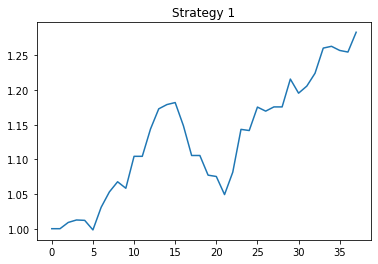

In [416]:
plt.plot([x for x in range(len(portfolio))], portfolio)
plt.title('Strategy 1')
plt.show()

In [418]:
# generating the stocks for the next week

starting_date1 = '20210531'
ending_date1 = '20210625'
portfolio = [1]

df_total = pd.DataFrame()
# containing the best formoing 50 funds
dfFunds = get_funds_ranking(starting_date1, ending_date1)
num_funds = 35
    
# we can set the select how many funds here
for index, row in dfFunds.iterrows():
    if int(index) < num_funds:
        url = row[-1]
        tempHoldings = get_holdings(url)
        time.sleep(1)
        df_total = pd.concat([df_total, tempHoldings], axis=0)

df_total.reset_index(inplace=True)
df_total.columns = ['股票代码', '股票名称']
stock_list = df_total['股票代码'].value_counts().to_frame()
# take the top 10 stocks
stock_list = stock_list.head(10)
stock_list['weight'] = stock_list['股票代码']/sum(stock_list['股票代码'])
stock_list.reset_index(inplace=True)
stock_list.columns = ['Tick', 'Number', 'Weight']
print(stock_list)

        Tick  Number    Weight
0  300750.SZ      15  0.180723
1  603501.SH      12  0.144578
2  300014.SZ       8  0.096386
3  300782.SZ       8  0.096386
4  300408.SZ       7  0.084337
5  601012.SH       7  0.084337
6  603986.SH       7  0.084337
7  000725.SZ       7  0.084337
8  600519.SH       7  0.084337
9  600460.SH       5  0.060241


# Period = 14 days

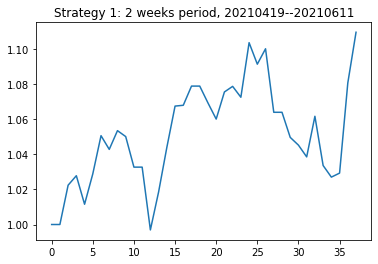

In [377]:
portfolio14 = portfolio
plt.plot([x for x in range(len(portfolio14))], portfolio14)
plt.title('Strategy 1: 2 weeks period, 20210419--20210611')
plt.show()

In [382]:
start = datetime.date(2021, 1 , 1)
end = datetime.date(2021, 3 , 31)
starting_date1 = '20210107'
ending_date1 = '20210331'
portfolio = [1]

df_total = pd.DataFrame()
# containing the best formoing 50 funds
dfFunds = get_funds_ranking(starting_date1, ending_date1)
num_funds = 25
    
# we can set the select how many funds here
for index, row in dfFunds.iterrows():
    if int(index) < num_funds:
        url = row[-1]
        tempHoldings = get_holdings(url)
        time.sleep(1)
        df_total = pd.concat([df_total, tempHoldings], axis=0)

df_total.reset_index(inplace=True)
df_total.columns = ['股票代码', '股票名称']
stock_list = df_total['股票代码'].value_counts().to_frame()
# take the top 10 stocks
stock_list = stock_list.head(10)
stock_list['weight'] = stock_list['股票代码']/sum(stock_list['股票代码'])
stock_list.reset_index(inplace=True)
stock_list.columns = ['Tick', 'Number', 'Weight']

starting_date2 = '20210407'
ending_date2 = '20210611'
tickStart = stock_list['Tick']
tick = tickStart[0]
num = len(ts.pro_bar(ts_code=tick, adj='qfq', start_date=starting_date2, end_date=ending_date2))
temp = np.array([0 for x in range(num)])
endingP = portfolio[-1]
for i in range(len(stock_list)):
    tick = tickStart[i]
    df_info = ts.pro_bar(ts_code=tick, adj='qfq', start_date=starting_date2, end_date=ending_date2)
    df_info = df_info[::-1].reset_index()
    price = df_info['close']
    share = endingP*stock_list.loc[i,'Weight']/price[0]
    value = np.array(price*share)
    len1 = len(value)
    while len1 < num:
        value = np.append(value, np.mean(value))
        len1 += 1
    temp = temp + value
endingP = temp[-1]
portfolio.extend(temp)
print(temp)

[1.         1.0105999  1.00010961 0.97348011 0.97478719 0.98032745
 0.98291751 0.99080715 1.01802309 1.01964945 1.01615736 1.02156636
 1.05156239 1.0511676  1.06211853 1.07249011 1.06632943 1.06026127
 1.06612646 1.0536953  1.06045551 1.05555046 1.06473028 1.03561543
 1.04631955 1.06088395 1.05200675 1.04303139 1.03976    1.02288241
 1.0247199  1.03528408 1.03363979 1.0340955  1.038276   1.06227488
 1.05936997 1.06477038 1.07348218 1.09967753 1.0971609  1.07903182
 1.08195089 1.08232971 1.07707564]


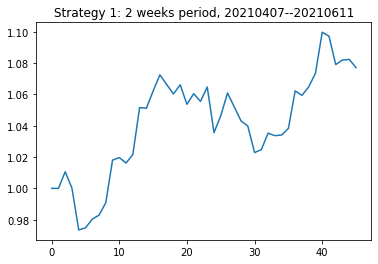

In [384]:
portfolio93 = portfolio
plt.plot([x for x in range(len(portfolio93))], portfolio93)
plt.title('Strategy 1: 2 weeks period, 20210407--20210611')
plt.show()

# Period = 30 days

In [397]:
starting_date1 = '20210407'
ending_date1 = '20210503'
portfolio = [1]

df_total = pd.DataFrame()
# containing the best formoing 50 funds
dfFunds = get_funds_ranking(starting_date1, ending_date1)
num_funds = 30
    
# we can set the select how many funds here
for index, row in dfFunds.iterrows():
    if int(index) < num_funds:
        url = row[-1]
        tempHoldings = get_holdings(url)
        time.sleep(1)
        df_total = pd.concat([df_total, tempHoldings], axis=0)

df_total.reset_index(inplace=True)
df_total.columns = ['股票代码', '股票名称']
stock_list = df_total['股票代码'].value_counts().to_frame()
# take the top 10 stocks
stock_list = stock_list.head(10)
stock_list['weight'] = stock_list['股票代码']/sum(stock_list['股票代码'])
stock_list.reset_index(inplace=True)
stock_list.columns = ['Tick', 'Number', 'Weight']

starting_date2 = '20210503'
ending_date2 = '20210620'
tickStart = stock_list['Tick']
tick = tickStart[0]
num = len(ts.pro_bar(ts_code=tick, adj='qfq', start_date=starting_date2, end_date=ending_date2))
temp = np.array([0 for x in range(num)])
endingP = portfolio[-1]
for i in range(len(stock_list)):
    tick = tickStart[i]
    df_info = ts.pro_bar(ts_code=tick, adj='qfq', start_date=starting_date2, end_date=ending_date2)
    df_info = df_info[::-1].reset_index()
    price = df_info['close']
    share = endingP*stock_list.loc[i,'Weight']/price[0]
    value = np.array(price*share)
    len1 = len(value)
    while len1 < num:
        value = np.append(value, np.mean(value))
        len1 += 1
    temp = temp + value
endingP = temp[-1]
portfolio.extend(temp)
print(temp)

[1.         0.96029452 0.97868366 1.00259602 1.03190256 1.0285641
 1.03632494 1.07473408 1.06400163 1.05581584 1.07537324 1.07850464
 1.07468955 1.10355558 1.09005917 1.09842753 1.06541871 1.08913022
 1.1188851  1.10478485 1.0940574  1.1147693  1.1090655  1.09526915
 1.09918205 1.12581356 1.11979136 1.11376456 1.05724323 1.08009946
 1.10528581]


# Period = 14 days ranging from 20210607 to 20210618

        Tick  Number    Weight
0  300750.SZ      21  0.161538
1  300014.SZ      18  0.138462
2  002709.SZ      17  0.130769
3  002460.SZ      14  0.107692
4  603799.SH      11  0.084615
5  300073.SZ      10  0.076923
6  002594.SZ      10  0.076923
7  300037.SZ      10  0.076923
8  002812.SZ      10  0.076923
9  601012.SH       9  0.069231
[1.         0.98555537 0.98977091 1.04139726 1.06417657 1.05535704
 0.98404866 1.01294177 1.05724236 1.0532879  1.05594471 1.08409877
 1.0728423 ]


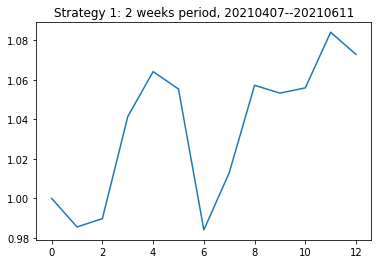

In [403]:
starting_date1 = '20210510'
ending_date1 = '20210604'
portfolio = [1]

df_total = pd.DataFrame()
# containing the best formoing 50 funds
dfFunds = get_funds_ranking(starting_date1, ending_date1)
num_funds = 45
    
# we can set the select how many funds here
for index, row in dfFunds.iterrows():
    if int(index) < num_funds:
        url = row[-1]
        tempHoldings = get_holdings(url)
        time.sleep(1)
        df_total = pd.concat([df_total, tempHoldings], axis=0)

df_total.reset_index(inplace=True)
df_total.columns = ['股票代码', '股票名称']
stock_list = df_total['股票代码'].value_counts().to_frame()
# take the top 10 stocks
stock_list = stock_list.head(10)
stock_list['weight'] = stock_list['股票代码']/sum(stock_list['股票代码'])
stock_list.reset_index(inplace=True)
stock_list.columns = ['Tick', 'Number', 'Weight']
print(stock_list)

starting_date2 = '20210607'
ending_date2 = '20210624'
tickStart = stock_list['Tick']
tick = tickStart[0]
num = len(ts.pro_bar(ts_code=tick, adj='qfq', start_date=starting_date2, end_date=ending_date2))
temp = np.array([0 for x in range(num)])
endingP = portfolio[-1]
for i in range(len(stock_list)):
    tick = tickStart[i]
    df_info = ts.pro_bar(ts_code=tick, adj='qfq', start_date=starting_date2, end_date=ending_date2)
    df_info = df_info[::-1].reset_index()
    price = df_info['close']
    share = endingP*stock_list.loc[i,'Weight']/price[0]
    value = np.array(price*share)
    len1 = len(value)
    while len1 < num:
        value = np.append(value, np.mean(value))
        len1 += 1
    temp = temp + value
endingP = temp[-1]
portfolio.extend(temp)
print(temp)

plt.plot([x for x in range(len(temp))], temp)
plt.title('Strategy 1: 2 weeks period, 20210407--20210611')
plt.show()

# Period = 30 days ranging from 20210524 to 20210618

In [401]:
starting_date1 = '20210524'
ending_date1 = '20210618'
portfolio = [1]

df_total = pd.DataFrame()
# containing the best formoing 50 funds
dfFunds = get_funds_ranking(starting_date1, ending_date1)
num_funds = 30
    
# we can set the select how many funds here
for index, row in dfFunds.iterrows():
    if int(index) < num_funds:
        url = row[-1]
        tempHoldings = get_holdings(url)
        time.sleep(1)
        df_total = pd.concat([df_total, tempHoldings], axis=0)

df_total.reset_index(inplace=True)
df_total.columns = ['股票代码', '股票名称']
stock_list = df_total['股票代码'].value_counts().to_frame()
# take the top 10 stocks
stock_list = stock_list.head(10)
stock_list['weight'] = stock_list['股票代码']/sum(stock_list['股票代码'])
stock_list.reset_index(inplace=True)
stock_list.columns = ['Tick', 'Number', 'Weight']
print(stock_list)

starting_date2 = '20210618'
ending_date2 = '20210624'
tickStart = stock_list['Tick']
tick = tickStart[0]
num = len(ts.pro_bar(ts_code=tick, adj='qfq', start_date=starting_date2, end_date=ending_date2))
temp = np.array([0 for x in range(num)])
endingP = portfolio[-1]
for i in range(len(stock_list)):
    tick = tickStart[i]
    df_info = ts.pro_bar(ts_code=tick, adj='qfq', start_date=starting_date2, end_date=ending_date2)
    df_info = df_info[::-1].reset_index()
    price = df_info['close']
    share = endingP*stock_list.loc[i,'Weight']/price[0]
    value = np.array(price*share)
    len1 = len(value)
    while len1 < num:
        value = np.append(value, np.mean(value))
        len1 += 1
    temp = temp + value
endingP = temp[-1]
portfolio.extend(temp)
print(temp)

        Tick  Number    Weight
0  300750.SZ      10  0.144928
1  603986.SH       8  0.115942
2  603501.SH       7  0.101449
3  300661.SZ       7  0.101449
4  688012.SH       7  0.101449
5  300014.SZ       7  0.101449
6  002415.SZ       7  0.101449
7  688536.SH       6  0.086957
8  002709.SZ       5  0.072464
9  002371.SZ       5  0.072464
[1.         0.99026032 0.9901523  1.02797218 1.00925095]


# Period = 90 days ranging from 20210101 to 20210331

In [ ]:
starting_date1 = '20210101'
ending_date1 = '20210331'
portfolio = [1]

df_total = pd.DataFrame()
# containing the best formoing 50 funds
dfFunds = get_funds_ranking(starting_date1, ending_date1)
num_funds = 30
    
# we can set the select how many funds here
for index, row in dfFunds.iterrows():
    if int(index) < num_funds:
        url = row[-1]
        tempHoldings = get_holdings(url)
        time.sleep(1)
        df_total = pd.concat([df_total, tempHoldings], axis=0)

df_total.reset_index(inplace=True)
df_total.columns = ['股票代码', '股票名称']
stock_list = df_total['股票代码'].value_counts().to_frame()
# take the top 10 stocks
stock_list = stock_list.head(10)
stock_list['weight'] = stock_list['股票代码']/sum(stock_list['股票代码'])
stock_list.reset_index(inplace=True)
stock_list.columns = ['Tick', 'Number', 'Weight']
print(stock_list)

starting_date2 = '20210618'
ending_date2 = '20210624'
tickStart = stock_list['Tick']
tick = tickStart[0]
num = len(ts.pro_bar(ts_code=tick, adj='qfq', start_date=starting_date2, end_date=ending_date2))
temp = np.array([0 for x in range(num)])
endingP = portfolio[-1]
for i in range(len(stock_list)):
    tick = tickStart[i]
    df_info = ts.pro_bar(ts_code=tick, adj='qfq', start_date=starting_date2, end_date=ending_date2)
    df_info = df_info[::-1].reset_index()
    price = df_info['close']
    share = endingP*stock_list.loc[i,'Weight']/price[0]
    value = np.array(price*share)
    len1 = len(value)
    while len1 < num:
        value = np.append(value, np.mean(value))
        len1 += 1
    temp = temp + value
endingP = temp[-1]
portfolio.extend(temp)
print(temp)

Then the next step is to scrap the next page with the same url

In [276]:
stock_list = df_total['股票代码'].value_counts().to_frame()
stock_list['weight'] = stock_list['股票代码']/sum(stock_list['股票代码'])
stock_list.reset_index(inplace=True)
stock_list.columns = ['Tick', 'Number', 'Weight']

portfolio = []
tickStart = stock_list['Tick']
tick = tickStart[0]
num = len(ts.pro_bar(ts_code=tick, adj='qfq', start_date='20210412', end_date='20210604'))
temp = np.array([0 for x in range(num)])
for i in range(len(stock_list)):
    tick = tickStart[i]
    df_info = ts.pro_bar(ts_code=tick, adj='qfq', start_date='20210412', end_date='20210604')
    df_info = df_info[::-1].reset_index()
    price = df_info['close']
    share = stock_list.loc[i,'Weight']/price[0]
    value = np.array(price*share)
    len1 = len(value)
    while len1 < num:
        value = np.append(value, np.mean(value))
        len1 += 1
    temp = temp + value
endingP = temp[-1]
portfolio.extend(temp)
print(temp)

[1.         1.00855599 1.05465957 1.05311466 1.04705956 1.11546837
 1.11107725 1.10979951 1.11510646 1.13268843 1.11692104 1.11749027
 1.14301927 1.14347015 1.16908171 1.15773127 1.1170608  1.12955281
 1.11080639 1.11322926 1.09150536 1.12347531 1.17780603 1.18001955
 1.22085634 1.22426741 1.22881103 1.24299343 1.25977598 1.24512294
 1.25318726 1.31052632 1.38215795 1.36930332 1.35906834 1.35176124
 1.38838565]


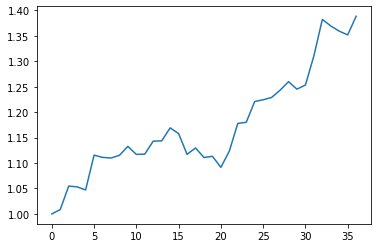

In [277]:
plt.plot([x for x in range(len(portfolio))], portfolio)
plt.show()